In [1]:
####IMPORTS

import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torchvision import transforms
import config
from tqdm import tqdm

import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchvision import transforms
from torch.utils.data import DataLoader

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
###Hyperparams
DEVICE = config.DEVICE
LEARNING_RATE = config.LEARNING_RATE
BATCH_SIZE = config.BATCH_SIZE
IMG_SIZE=config.IMG_SIZE
CHANNELS_IMG=config.CHANNELS_IMG
L1_LAMBDA = config.L1_LAMBDA
LAMBDA_GP = config.LAMBDA_GP
NUM_EPOCHS = config.NUM_EPOCHS
LOAD_MODEL = config.LOAD_MODEL
SAVE_MODEL = config.SAVE_MODEL
CHECKPOINT_DISC = config.CHECKPOINT_DISC
CHECKPOINT_GEN = config.CHECKPOINT_GEN

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

test_raw='/content/drive/MyDrive/Task 2/Test/Raw'
test_ref='/content/drive/MyDrive/Task 2/Test/Reference'
train_raw='/content/drive/MyDrive/Task 2/Train/Raw'
train_ref='/content/drive/MyDrive/Task 2/Train/Reference'

Mounted at /content/drive


In [4]:
from dataset import load_dataset
raw_folder = train_raw
ref_folder = train_ref
dataloader = load_dataset(raw_folder, ref_folder)

In [12]:
import torch
from utils import save_checkpoint, load_checkpoint, save_some_examples
import torch.nn as nn
import torch.optim as optim
import config
from gen_model import Generator
from discrim_model import Discriminator
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
from train import train_fn
torch.backends.cudnn.benchmark = True
from utils import save_some_examples, save_checkpoint, load_checkpoint
import matplotlib.pyplot as plt

In [22]:
def display_image_pairs(folder="/content/evaluation", max_index=NUM_EPOCHS-10, step=10):
    
    for i in range(0, max_index + 1, step):
        input_image_path = os.path.join(folder, f"input_{i}.png")
        generated_image_path = os.path.join(folder, f"y_gen_{i}.png")

        input_image = Image.open(input_image_path)
        generated_image = Image.open(generated_image_path)


        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Display input image
        axes[0].imshow(input_image)
        axes[0].set_title(f'Input {i}')
        axes[0].axis('off')  # Hide axes

        # Display generated image
        axes[1].imshow(generated_image)
        axes[1].set_title(f'Generated {i}')
        axes[1].axis('off')  # Hide axes

        # Show the plot
        plt.show()



In [16]:
def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()



    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)

    # Dataset and DataLoader
    dataloader_train = load_dataset(raw_folder=train_raw, ref_folder=train_ref)
    dataloader_test = load_dataset(raw_folder=test_raw, ref_folder=test_ref)
    train_loader = dataloader_train
    test_loader = dataloader_test

    g_scaler = torch.amp.GradScaler()
    d_scaler = torch.amp.GradScaler()

    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
        
        if SAVE_MODEL and epoch % 10 == 0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

        
        save_some_examples(gen, test_loader, epoch, folder="/content/evaluation")


if __name__ == "__main__":
    main()


100%|██████████| 43/43 [00:51<00:00,  1.19s/it, D_fake=0.0665, D_real=0.97]


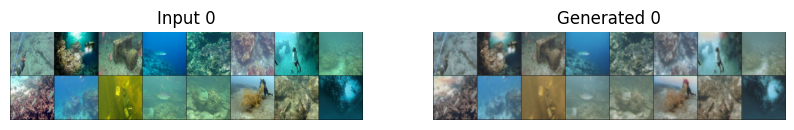

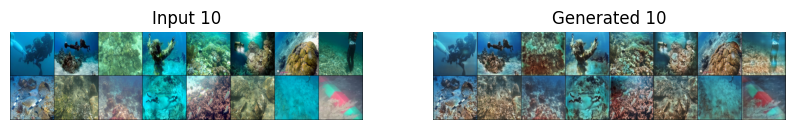

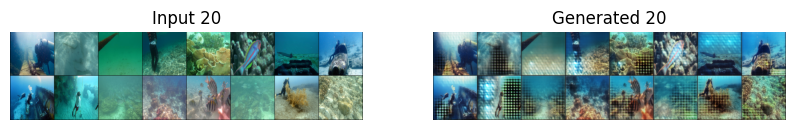

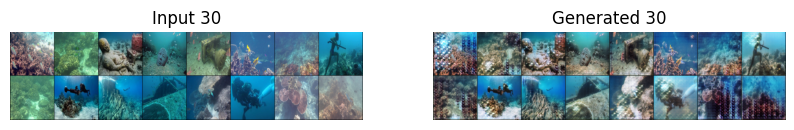

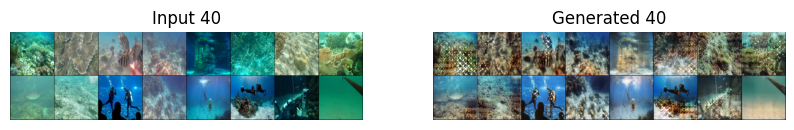

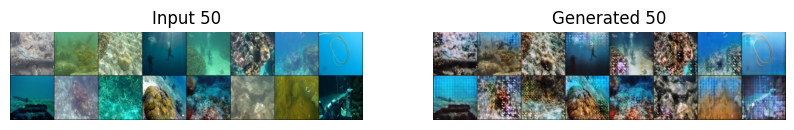

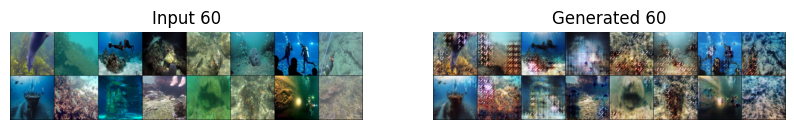

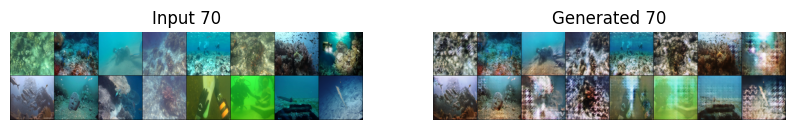

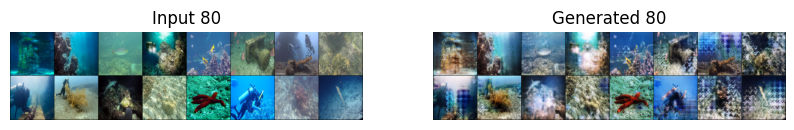

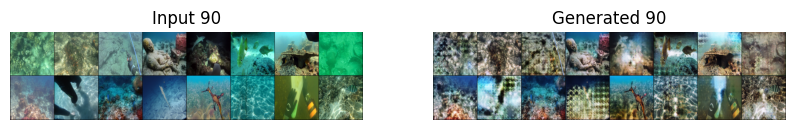

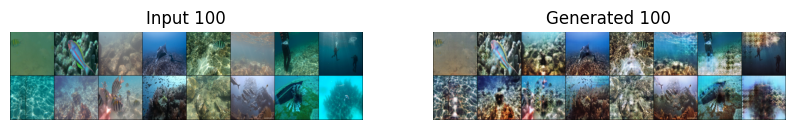

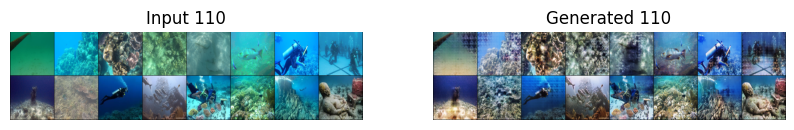

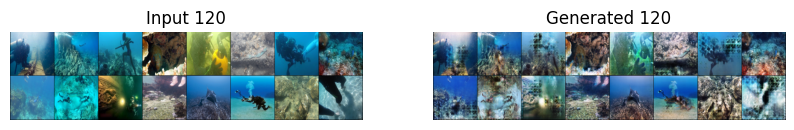

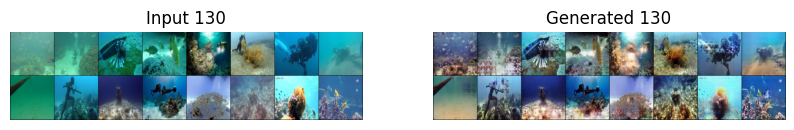

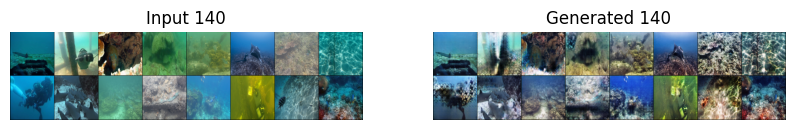

In [23]:
display_image_pairs()